# Filling gaps in time series

1. Several tools we used to explore time series requires we have continuous data (no gaps). 

2. In order to fill the gaps in a time-series, we need to find the gaps and asses the lenght of the gaps.   

3. From observational data, is not uncomon to find short gaps. For example, during instrumnet maintenance, we retrieve and redeploy the instrument, creating a gap. Luckly, of few hours only... 

4. Here we will do that with hourly data of wind from a meteorological station. We can fill gaps about several hours, maybe a day or two... if you have a long time series (years!).

5. WARNING: each data set has it own particularities, about how it was generated, managed, etc... consequently, for each one the way of how to fill the gaps must be assessed! No general rule exist!!

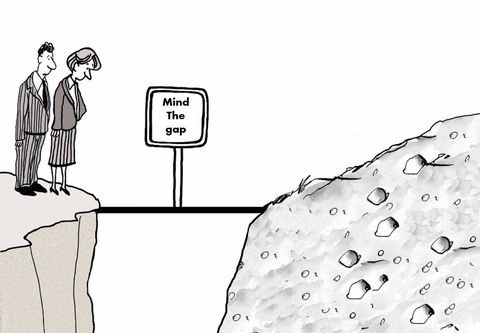


In [20]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [6]:
# load the preprocessed (hourly) data of the met station 
# preprocessed in: "Vento_Ajuruteua_preprocessa.ipynb" 
# j = [hdr, tid, pre2, tem2, umi2, u2, v2]

path = r'd:\GUTO\1_Trabs\2_Plataforma\Para\Rotinas\\'

with open(path + 'Dados_Meteorologicos_Ajuruteua_reduzidos_1h.pkl', 'rb') as io:
    aju = pickle.load(io)

aju_t = np.array(aju[1])
aju_u = np.array(aju[5]) *-1  # to change to vector notation
aju_v = np.array(aju[6]) *-1 

### Checking the consistence of the time-series!

Is the time homogeneous? I mean, regularly spaced... if it is, when ploted, it will appear as a straigh line. 

In [7]:
print(aju_t[0])
print(aju_t[-1])

2015-10-03 18:00:00+00:00
2017-10-20 08:00:00.001880+00:00


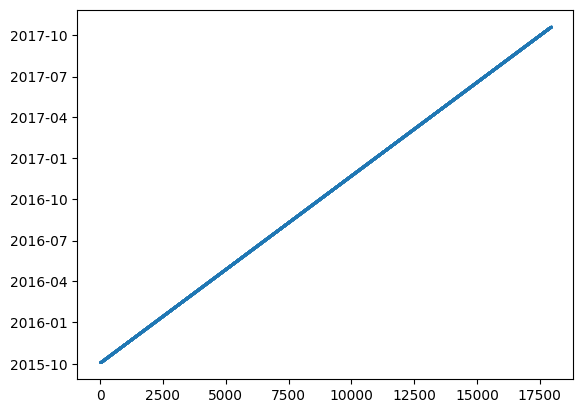

In [23]:
plt.plot(aju_t, '.', ms=1)

### Further checking the sampling interval (hourly!)

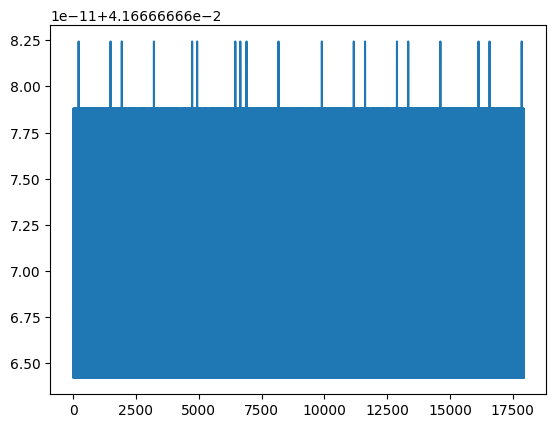

In [22]:
aju_tn = mdates.date2num(aju_t)

plt.plot(np.diff(aju_tn))

### Checking the data!

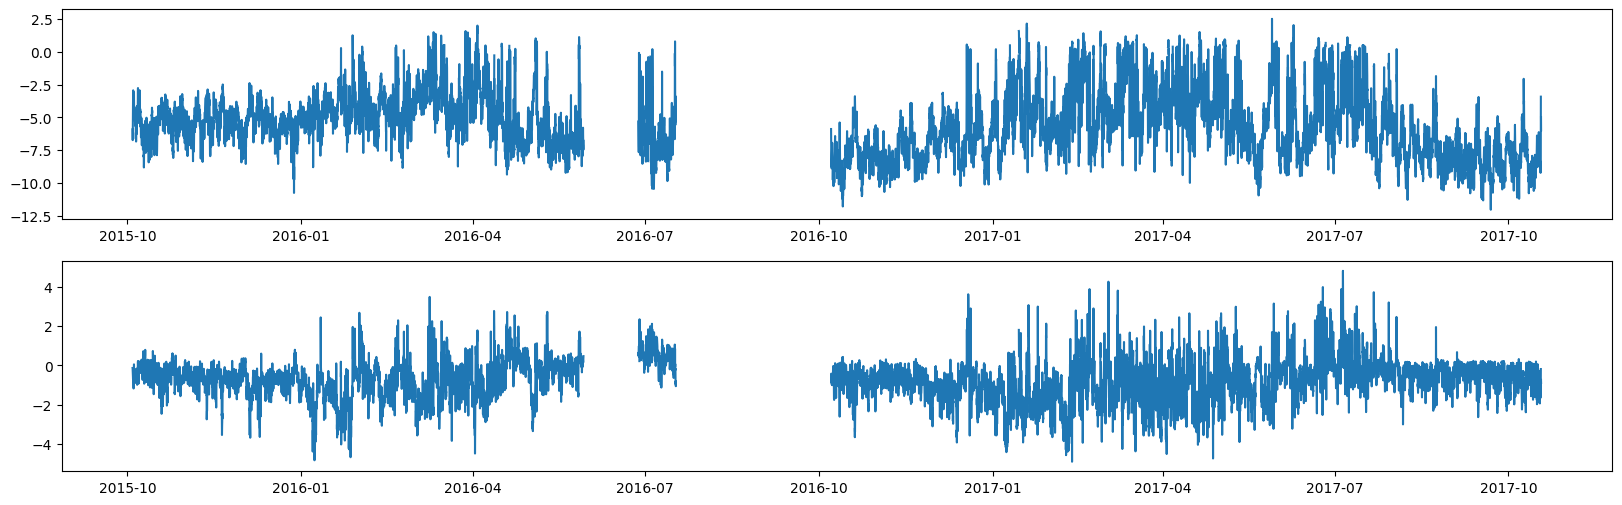

In [15]:
fig, axs = plt.subplots(2, figsize=(20,6))

axs[0].plot(aju_t, aju_u)
axs[1].plot(aju_t, aju_v)

### Checking the gaps...

From the figure above, it is obvious there are two big interruptions, which are not possible to fill using interpolation. We can fill these using correlation with other wind data, from other met stations or wind model products such as ERA or WW3.  

However, as we are seeing a quite long time series of hourly data, we can't see small gaps. 

As we saw above, there are 'time' for all period, and the absence of data is filled with 'Not-a-numbers'.

### Checking nan

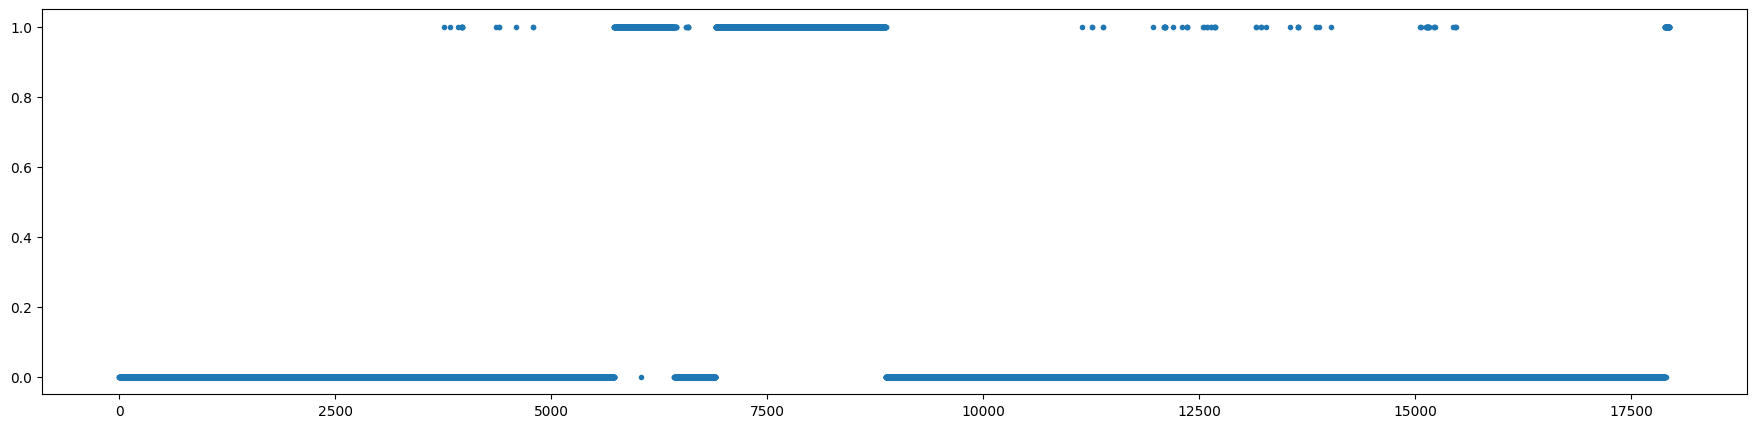

In [13]:
is_nan = np.isnan(aju_u)

fig, axs = plt.subplots(figsize=(22,5))
axs.plot(is_nan, '.')

So, here we are... many small gaps.   

If there only these small gaps, the easiest way to solve the problem would be to exclude the elements from the array (time and wind), so we would have time/wind without nans, and interpolate the wind to the original 'time'. 

We can't do this here... first we need to asses the length of the gaps.

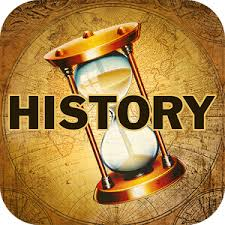
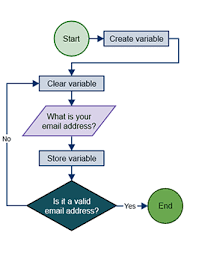

The first time I did this was in 2020... the result is the function 'find_nans'. It works... but definitvly, it is not 'elegant'. Recently (2023) I was revisiting this problem and decided that funcion is stupid the way I built it, and did it again from the scratch. 

So, there are many possible solutions for a give problem... if you find a solution that workds, excelent. It doesn't matter how uggly it is. But, it is nice to 'evolve' and try to improve your coding skills. 

In [50]:
# made in 2020 [and don't work if there are nan at the end of the array!]
def find_nans(x):
    
    x = np.isnan(x)*1
    
    i = 0
    i_1st_nan = []
    len_nan = []
    while i < len(x)-1:
        
        # condition when the 1st value is 1 (nan)
        if i == 0 and x[i] == 1:
            i_1st_nan.append(0)

            j = i + 1
            c = 0
            while x[j] == 1:
                c += 1
                j += 1
            len_nan.append(c+1)     

        # condition for the rest of the array        
        j = i + 1
        if x[j] > x[i]:
            i_1st_nan.append(j)

            c = 0
            while x[j] > x[i]:
                c += 1
                j += 1

                if j == len(x)-1: # condition for the last value
                    if x[i] == 1:
                        c += 1
                    else:
                        break

            len_nan.append(c)   

        i += 1
        
    return i_1st_nan, len_nan

In [25]:
# made in 2023
def find_nans_2(x):
    is_nan = np.isnan(x)*1 # True = 1, False = 0
    
    #insert a last element 0 to avoid problems
    is_nan = np.append(is_nan, 0)
    
    idx_1st_nan = [] # where the gaps are
    len_nan = [] # how long the gaps are
    i = 0
    while i < len(is_nan):
        if is_nan[i] == 1:
            idx_1st_nan.append(i)  
            i += 1
            c = 1
    
            while is_nan[i] == 1:
                c += 1
                i += 1
            len_nan.append(c)
        i += 1

    return idx_1st_nan, len_nan

### Testing the functions!

When creating a dummy array to test a function, it doesn't need be large, but need to have all sort of difficulties you expect to have!

In [52]:
dummy = np.array([1, np.nan, 1, np.nan, np.nan, 1, 1, np.nan, np.nan])

a, b = find_nans(dummy)
print(a)
print(b)

a, b = find_nans_2(dummy)
print(a)
print(b)

[1, 3, 7]
[1, 2, 1]
[1, 3, 7]
[1, 2, 2]


### Going on...

We have that most gaps are quite short!

Text(0, 0.5, 'Gap length')

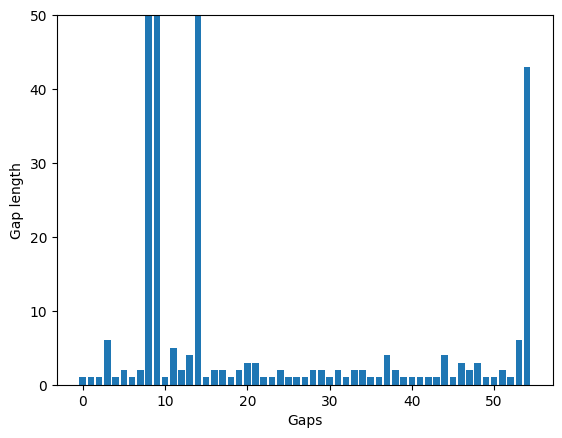

In [59]:
i_nan, l_nan = find_nans_2(aju_u)

plt.bar(np.arange(0, len(l_nan)), l_nan)
plt.ylim(0, 50)
plt.xlabel('Gaps')
plt.ylabel('Gap length')

### Creating and testing the algorithm to fill the gaps

In [79]:
x = aju_u

for i in range(3, len(i_nan)):

    print(x[i_nan[i] - 1 : i_nan[i] + l_nan[i] + 1 ])
    if l_nan[i] < 10:
    
        x1 = x[i_nan[i] -1]
        xn = x[i_nan[i] + l_nan[i]]

        xi = np.linspace(x1, xn, l_nan[i] + 2)

        x[i_nan[i] - 1 : i_nan[i] + l_nan[i] + 1 ] = xi

    print(x[i_nan[i] - 1 : i_nan[i] + l_nan[i] + 1 ])
    
    print(l_nan[i])
    print(len(xi))
    break

[ 0.50113808         nan         nan         nan         nan         nan
         nan -0.99483033]
[ 0.50113808  0.28742831  0.07371854 -0.13999124 -0.35370101 -0.56741078
 -0.78112055 -0.99483033]
6
8


In [81]:
def fill_gaps(x, i_nan, l_nan):

    for i in range(len(i_nan)):

        if l_nan[i] < 10:
        
            x1 = x[i_nan[i] -1]
            xn = x[i_nan[i] + l_nan[i]]
    
            xi = np.linspace(x1, xn, l_nan[i] + 2)
    
            x[i_nan[i] - 1 : i_nan[i] + l_nan[i] + 1 ] = xi

    return x

In [83]:
aju_u = fill_gaps(aju_u, i_nan, l_nan)
aju_v = fill_gaps(aju_v, i_nan, l_nan)

### Checking nans again

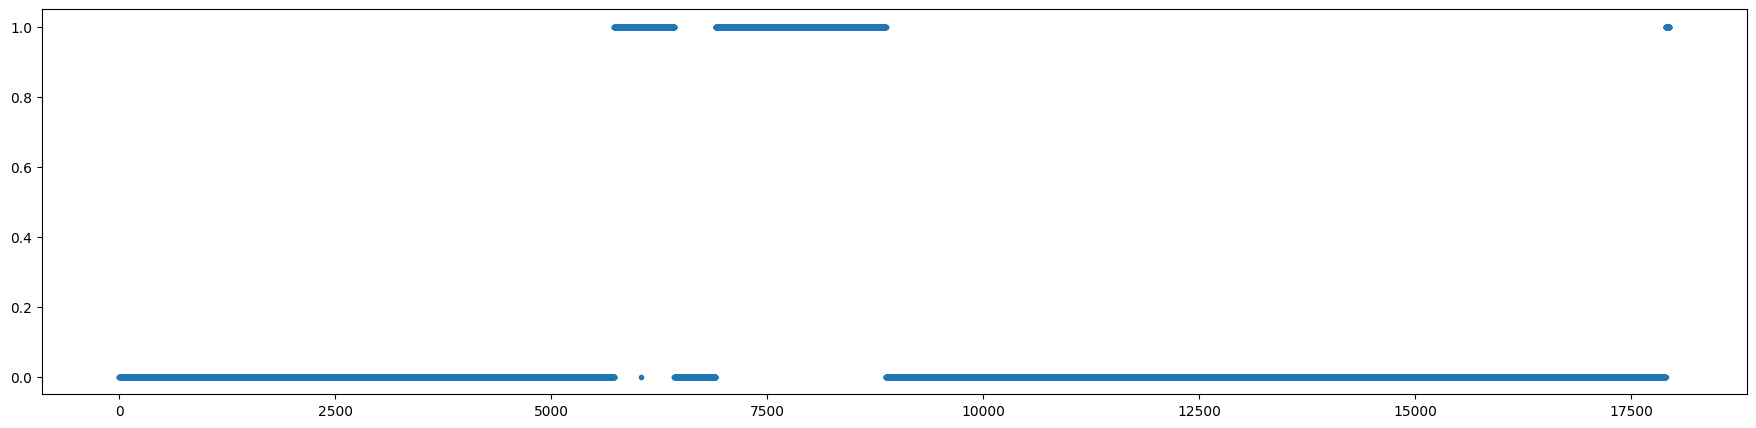

In [84]:
is_nan = np.isnan(aju_u)

fig, axs = plt.subplots(figsize=(22,5))
axs.plot(is_nan, '.')

# Done 


In [91]:
# updating the header
x = aju[0]

complemento = '\n Os dados de velocidade do vento foram processados para remoção de pequenos gaps em <Wind_Aju_fill_the_gaps>, em 12/set/2032 \n'
x = x + complemento

In [92]:
print(x)

 
Dados reduzidos de vento da estação de Ajuruteua <Vento_Ajuruteua_preprocessa.ipynb>

dadso =[tempo, pressao, umidade, u, v]

u e v estão em notação meteorológica

 Os dados de velocidade do vento foram processados para remoção de pequenos gaps em <Wind_Aju_fill_the_gaps>, em 12/set/2032 



In [ ]:
aju[0] = x
aju[5] = aju_u
aju[6] = aju_v

path = r'd:\GUTO\1_Trabs\2_Plataforma\Para\Rotinas\\'

with open(path + 'Dados_Meteorologicos_Ajuruteua_reduzidos_1h_b.pkl', 'rb') as io:
    aju = pickle.load(io)
